In [1]:
!pip install rdkit-pypi

     |████████████████████████████████| 22.5 MB 1.5 MB/s 


In [2]:
from collections import defaultdict
import os
import pickle

import sys

import numpy as np

from rdkit import Chem


def create_atoms(mol):
    """Create a list of atom (e.g., hydrogen and oxygen) IDs
    considering the aromaticity."""
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    for a in mol.GetAromaticAtoms():
        i = a.GetIdx()
        atoms[i] = (atoms[i], 'aromatic')
    atoms = [atom_dict[a] for a in atoms]
    return np.array(atoms)


def create_ijbonddict(mol):
    """Create a dictionary, which each key is a node ID
    and each value is the tuples of its neighboring node
    and bond (e.g., single and double) IDs."""
    i_jbond_dict = defaultdict(lambda: [])
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bond = bond_dict[str(b.GetBondType())]
        i_jbond_dict[i].append((j, bond))
        i_jbond_dict[j].append((i, bond))
    return i_jbond_dict


def extract_fingerprints(atoms, i_jbond_dict, radius):
    """Extract the r-radius subgraphs (i.e., fingerprints)
    from a molecular graph using Weisfeiler-Lehman algorithm."""

    if (len(atoms) == 1) or (radius == 0):
        fingerprints = [fingerprint_dict[a] for a in atoms]

    else:
        nodes = atoms
        i_jedge_dict = i_jbond_dict

        for _ in range(radius):

            """Update each node ID considering its neighboring nodes and edges
            (i.e., r-radius subgraphs or fingerprints)."""
            fingerprints = []
            for i, j_edge in i_jedge_dict.items():
                neighbors = [(nodes[j], edge) for j, edge in j_edge]
                fingerprint = (nodes[i], tuple(sorted(neighbors)))
                fingerprints.append(fingerprint_dict[fingerprint])
            nodes = fingerprints

            """Also update each edge ID considering two nodes
            on its both sides."""
            _i_jedge_dict = defaultdict(lambda: [])
            for i, j_edge in i_jedge_dict.items():
                for j, edge in j_edge:
                    both_side = tuple(sorted((nodes[i], nodes[j])))
                    edge = edge_dict[(both_side, edge)]
                    _i_jedge_dict[i].append((j, edge))
            i_jedge_dict = _i_jedge_dict

    return np.array(fingerprints)


def create_adjacency(mol):
    adjacency = Chem.GetAdjacencyMatrix(mol)
    return np.array(adjacency)


def split_sequence(sequence, ngram):
    sequence = '-' + sequence + '='
    words = [word_dict[sequence[i:i+ngram]]
             for i in range(len(sequence)-ngram+1)]
    return np.array(words)


def dump_dictionary(dictionary, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dict(dictionary), f)

r-radius is 2, n-gram is 3, window size is 11, vector dimensionality is 10, number of time steps in GNN is 3, and number of layers in CNN is 3.

In [5]:
radius, ngram = map(int, [2, 3])

In [6]:
with open('/content/data.txt', 'r') as f:
        data_list = f.read().strip().split('\n')

data_list = [d for d in data_list if '.' not in d.strip().split()[0]]
N = len(data_list)

atom_dict = defaultdict(lambda: len(atom_dict))
bond_dict = defaultdict(lambda: len(bond_dict))
fingerprint_dict = defaultdict(lambda: len(fingerprint_dict))
edge_dict = defaultdict(lambda: len(edge_dict))
word_dict = defaultdict(lambda: len(word_dict))

Smiles, compounds, adjacencies, proteins, interactions = '', [], [], [], []

for no, data in enumerate(data_list):

  #print('/'.join(map(str, [no+1, N])))

  smiles, sequence, interaction = data.strip().split()
  Smiles += smiles + '\n'

  mol = Chem.AddHs(Chem.MolFromSmiles(smiles))  # Consider hydrogens.
  atoms = create_atoms(mol)
  i_jbond_dict = create_ijbonddict(mol)

  fingerprints = extract_fingerprints(atoms, i_jbond_dict, radius)
  compounds.append(fingerprints)

  adjacency = create_adjacency(mol)
  adjacencies.append(adjacency)

  words = split_sequence(sequence, ngram)
  proteins.append(words)

  interactions.append(np.array([float(interaction)]))

In [7]:
dir_input = ('/content/input/'
                 'radius' + str(radius) + '_ngram' + str(ngram) + '/')
os.makedirs(dir_input, exist_ok=True)

with open(dir_input + 'Smiles.txt', 'w') as f:
    f.write(Smiles)
np.save(dir_input + 'compounds', compounds)
np.save(dir_input + 'adjacencies', adjacencies)
np.save(dir_input + 'proteins', proteins)
np.save(dir_input + 'interactions', interactions)
dump_dictionary(fingerprint_dict, dir_input + 'fingerprint_dict.pickle')
dump_dictionary(word_dict, dir_input + 'word_dict.pickle')

print('preprocessing finished!')

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


preprocessing finished!


In [17]:
with open('/content/tox21.txt', 'r') as f:
        data_list = f.read().strip().split('\n')
data_list = data_list[10:446]
data_list = [d for d in data_list if '.' not in d.strip().split()[0]]
N = len(data_list)

atom_dict = defaultdict(lambda: len(atom_dict))
bond_dict = defaultdict(lambda: len(bond_dict))
fingerprint_dict = defaultdict(lambda: len(fingerprint_dict))
edge_dict = defaultdict(lambda: len(edge_dict))
word_dict = defaultdict(lambda: len(word_dict))

Smiles, compounds, adjacencies, proteins, interactions = '', [], [], [], []

for no, data in enumerate(data_list):

  #print('/'.join(map(str, [no+1, N])))

  smiles, interaction = data.strip().split()
  Smiles += smiles + '\n'

  mol = Chem.AddHs(Chem.MolFromSmiles(smiles))  # Consider hydrogens.
  atoms = create_atoms(mol)
  i_jbond_dict = create_ijbonddict(mol)

  fingerprints = extract_fingerprints(atoms, i_jbond_dict, radius)
  compounds.append(fingerprints)

  adjacency = create_adjacency(mol)
  adjacencies.append(adjacency)

  words = split_sequence(" ", ngram)
  proteins.append(words)

  interactions.append(np.array([float(interaction.replace("\\",""))]))

In [18]:
dir_input = ('/content/newinput/'
                 'radius' + str(radius) + '_ngram' + str(ngram) + '/')
os.makedirs(dir_input, exist_ok=True)

with open(dir_input + 'Smiles.txt', 'w') as f:
    f.write(Smiles)
np.save(dir_input + 'compounds', compounds)
np.save(dir_input + 'adjacencies', adjacencies)
np.save(dir_input + 'proteins', proteins)
np.save(dir_input + 'interactions', interactions)
dump_dictionary(fingerprint_dict, dir_input + 'fingerprint_dict.pickle')
dump_dictionary(word_dict, dir_input + 'word_dict.pickle')

print('preprocessing finished!')

preprocessing finished!


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [8]:

dim = 10
layer_gnn = 3
window = 11
layer_cnn = 3
layer_output = 3
decay_interval = 10
iteration = 100
lr = 1e-4
lr_decay = 0.5
weight_decay = 1e-6

(dim, layer_gnn, window, layer_cnn, layer_output, decay_interval,
  iteration) = map(int, [dim, layer_gnn, window, layer_cnn, layer_output,
                        decay_interval, iteration])
lr, lr_decay, weight_decay = map(float, [lr, lr_decay, weight_decay])

In [9]:
import pickle
import sys
import timeit

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import roc_auc_score, precision_score, recall_score
import networkx as nx

In [47]:

class CompoundProteinInteractionPrediction(nn.Module):
    def __init__(self):
        super(CompoundProteinInteractionPrediction, self).__init__()
        self.embed_fingerprint = nn.Embedding(n_fingerprint, dim)
        self.embed_word = nn.Embedding(n_word, dim)
        
        self.W_gnn = nn.ModuleList([nn.Linear(dim, dim)
                                    for _ in range(layer_gnn)])
        self.W_cnn = nn.ModuleList([nn.Conv2d(
                     in_channels=1, out_channels=1, kernel_size=2*window+1,
                     stride=1, padding=window) for _ in range(layer_cnn)])
        self.W_attention = nn.Linear(dim, dim)
        self.W_out = nn.ModuleList([nn.Linear(2*dim, 2*dim)
                                    for _ in range(layer_output)])
        self.W_interaction = nn.Linear(2*dim, 2)

    def gnn(self, xs, A, layer):
        for i in range(layer):
            hs = torch.relu(self.W_gnn[i](xs))
            xs = xs + torch.matmul(A, hs)
        # return torch.unsqueeze(torch.sum(xs, 0), 0)
        return torch.unsqueeze(torch.mean(xs, 0), 0)

    def attention_cnn(self, x, xs, layer):
        """The attention mechanism is applied to the last layer of CNN."""

        xs = torch.unsqueeze(torch.unsqueeze(xs, 0), 0)
        for i in range(layer):
            xs = torch.relu(self.W_cnn[i](xs))
        xs = torch.squeeze(torch.squeeze(xs, 0), 0)
        h = torch.relu(self.W_attention(x))
        hs = torch.relu(self.W_attention(xs))
        weights = torch.tanh(F.linear(h, hs))
        ys = torch.t(weights) * hs
        # return torch.unsqueeze(torch.sum(ys, 0), 0)
        return torch.unsqueeze(torch.mean(ys, 0), 0)

    def forward(self, inputs):

        fingerprints, adjacency, words = inputs

        """Compound vector with GNN."""
        fingerprint_vectors = self.embed_fingerprint(fingerprints)
        compound_vector = self.gnn(fingerprint_vectors, adjacency, layer_gnn)
    
        """Protein vector with attention-CNN."""
        word_vectors = self.embed_word(words)
        protein_vector = self.attention_cnn(compound_vector,
                                            word_vectors, layer_cnn)
        if(protein_vector[0][0]!=0):
          #print("cnn+gnn")
          cat_vector = torch.cat((compound_vector, protein_vector), 1)
        else:
          #print("gnn only")
          b = protein_vector*0
          cat_vector = torch.cat((compound_vector, b), 1)
          
        for j in range(layer_output):
            cat_vector = torch.relu(self.W_out[j](cat_vector))

        interaction = self.W_interaction(cat_vector)
        return interaction, compound_vector, fingerprint_vectors, adjacency

    def __call__(self, data, train=True):

        inputs, correct_interaction = data[:-1], data[-1]
        predicted_interaction, cv, fv, adj = self.forward(inputs)

        if train:
            loss = F.cross_entropy(predicted_interaction, correct_interaction)
            return loss
        else:
            correct_labels = correct_interaction.to('cpu').data.numpy()
            ys = F.softmax(predicted_interaction, 1).to('cpu').data.numpy()
            predicted_labels = list(map(lambda x: np.argmax(x), ys))
            predicted_scores = list(map(lambda x: x[1], ys))
            return correct_labels, predicted_labels, predicted_scores, predicted_interaction, cv, fv, adj


class Trainer(object):
    def __init__(self, model):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=lr, weight_decay=weight_decay)

    def train(self, dataset):
        np.random.shuffle(dataset)
        N = len(dataset)
        loss_total = 0
        for data in dataset:
            loss = self.model(data)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_total += loss.to('cpu').data.numpy()
            #print("i am working")
        return loss_total


class Tester(object):
    def __init__(self, model):
        self.model = model

    def test(self, dataset):
        N = len(dataset)
        T, Y, S = [], [], []
        
        for data in dataset:
            (correct_labels, predicted_labels,
             predicted_scores, pi, cv, fv, adj) = self.model(data, train=False)
            T.append(correct_labels)
            Y.append(predicted_labels)
            S.append(predicted_scores)
        AUC = roc_auc_score(T, S)
        
        precision = precision_score(T, Y)
        recall = recall_score(T, Y)
        return AUC, precision, recall, pi, cv, fv, adj

    def save_AUCs(self, AUCs, filename):
        with open(filename, 'a') as f:
            f.write('\t'.join(map(str, AUCs)) + '\n')

    def save_model(self, model, filename):
        torch.save(model.state_dict(), filename)


def load_tensor(file_name, dtype):
    return [dtype(d).to(device) for d in np.load(file_name + '.npy', allow_pickle=True)]



def load_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)


def shuffle_dataset(dataset, seed):
    np.random.seed(seed)
    np.random.shuffle(dataset)
    return dataset


def split_dataset(dataset, ratio):
    n = int(ratio * len(dataset))
    dataset_1, dataset_2 = dataset[:n], dataset[n:]
    return dataset_1, dataset_2


In [48]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('The code uses GPU...')
else:
  device = torch.device('cpu')
  print('The code uses CPU!!!')

dir_input = ('/content/input/'
                 'radius' + str(radius) + '_ngram' + str(ngram) + '/')

"load data"
compounds = load_tensor(dir_input + 'compounds', torch.LongTensor)
adjacencies = load_tensor(dir_input + 'adjacencies', torch.FloatTensor)
proteins = load_tensor(dir_input + 'proteins', torch.LongTensor)
interactions = load_tensor(dir_input + 'interactions', torch.LongTensor)
fingerprint_dict = load_pickle(dir_input + 'fingerprint_dict.pickle')
word_dict = load_pickle(dir_input + 'word_dict.pickle')
n_fingerprint = len(fingerprint_dict)
n_word = len(word_dict)

The code uses GPU...


In [49]:
"""Create a dataset and split it into train/dev/test."""
dataset = list(zip(compounds, adjacencies, proteins, interactions))
dataset = shuffle_dataset(dataset, 1234)
dataset_train, dataset_ = split_dataset(dataset, 0.8)
dataset_dev, dataset_test = split_dataset(dataset_, 0.5)

r-radius is 2, n-gram is 3, window size is 11, vector dimensionality is 10, number of time steps in GNN is 3, and number of layers in CNN is 3.

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

In [16]:
print(model)

CompoundProteinInteractionPrediction(
  (embed_fingerprint): Embedding(6341, 10)
  (embed_word): Embedding(8393, 10)
  (W_gnn): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
  (W_cnn): ModuleList(
    (0): Conv2d(1, 1, kernel_size=(23, 23), stride=(1, 1), padding=(11, 11))
    (1): Conv2d(1, 1, kernel_size=(23, 23), stride=(1, 1), padding=(11, 11))
    (2): Conv2d(1, 1, kernel_size=(23, 23), stride=(1, 1), padding=(11, 11))
  )
  (W_attention): Linear(in_features=10, out_features=10, bias=True)
  (W_out): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
  (W_interaction): Linear(in_features=20, out_features=2, bias=True)
)


In [ ]:
adjacency = adj.cpu().numpy()

In [ ]:
fv.shape

torch.Size([37, 10])

In [ ]:
import pandas as pd
import networkx as nx
G = nx.DiGraph(adjacency)

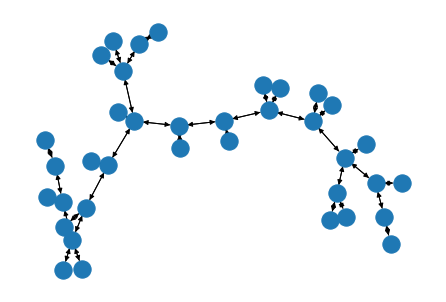

In [ ]:
nx.draw(G)


In [ ]:
protein_vector

NameError: ignored

In [50]:
"set model"
torch.manual_seed(1234)
model = CompoundProteinInteractionPrediction().to(device)
trainer = Trainer(model)
tester = Tester(model)

Training...
1	26.79550110299988	3046.601733366959	0.8377567960157709	0.8058553411207042	0.732360097323601	0.840782122905028
2	54.145310131999395	2354.724982572254	0.8724735422286782	0.8471940071102082	0.8162650602409639	0.7569832402234636
3	81.03496624199943	2109.1090418600943	0.8913882548246523	0.8757300660233621	0.8263305322128851	0.8240223463687151
4	108.23721200199998	1900.095303047914	0.9035484540361071	0.8986054680887083	0.8141361256544503	0.8687150837988827
5	135.030825758	1688.6910308588122	0.9202946669433492	0.9127518198747249	0.887240356083086	0.835195530726257


KeyboardInterrupt: ignored

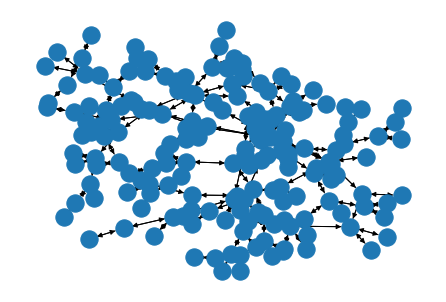

In [51]:
"""Start training."""

print('Training...')

start = timeit.default_timer()
totauc = []
totlosst = []
totprec = []
totrecall = []
for epoch in range(1, iteration):

  if epoch % decay_interval == 0:
      trainer.optimizer.param_groups[0]['lr'] *= lr_decay
  
  loss_train = trainer.train(dataset_train)
  AUC_test, precision_test, recall_test, pi, cv, fv, adj = tester.test(dataset_test)
  AUC_dev = tester.test(dataset_dev)[0]
  end = timeit.default_timer()
  time = end - start

  AUCs = [epoch, time, loss_train, AUC_dev,
          AUC_test, precision_test, recall_test]
  totauc.append(AUC_test)
  totlosst.append(loss_train)
  totprec.append(precision_test)
  totrecall.append(recall_test)
  #tester.save_AUCs(AUCs, file_AUCs)

  print('\t'.join(map(str, AUCs)))
  adjacency = adj.cpu().numpy()
  G = nx.DiGraph(adjacency)
  nx.draw(G)

Text(0.5, 0, 'epoch')

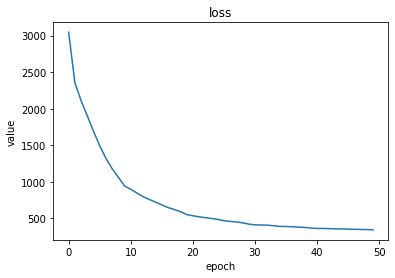

In [28]:
plt.plot(totauc[:50])
plt.title("AUC")
plt.ylabel("AUC score")
plt.xlabel("epoch")


plt.plot(totlosst[:50])
plt.title("loss")
plt.ylabel("value")
plt.xlabel("epoch")




In [ ]:
model.W_gnn[2]




Linear(in_features=10, out_features=10, bias=True)

In [52]:
for param in model.parameters():
    param.requires_grad = True
    
for name, child in model.named_children():
   if name in ['W_gnn']:
      child = model.W_gnn[2]
      print(name + ' is unfrozen')
      for param in child.parameters():
          param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False    

embed_fingerprint is frozen
embed_word is frozen
W_gnn is unfrozen
W_cnn is frozen
W_attention is frozen
W_out is frozen
W_interaction is frozen


In [39]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0006, momentum=0.9)

In [53]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('The code uses GPU...')
else:
  device = torch.device('cpu')
  print('The code uses CPU!!!')

dir_input = ('/content/newinput/'
                 'radius' + str(radius) + '_ngram' + str(ngram) + '/')

"load data"
compounds = load_tensor(dir_input + 'compounds', torch.LongTensor)
adjacencies = load_tensor(dir_input + 'adjacencies', torch.FloatTensor)
proteins = load_tensor(dir_input + 'proteins', torch.LongTensor)
interactions = load_tensor(dir_input + 'interactions', torch.LongTensor)
fingerprint_dict = load_pickle(dir_input + 'fingerprint_dict.pickle')
word_dict = load_pickle(dir_input + 'word_dict.pickle')
n_fingerprint = len(fingerprint_dict)
n_word = len(word_dict)

The code uses GPU...


In [ ]:
word_dict

{}

In [54]:
"""Create a dataset and split it into train/dev/test."""
dataset = list(zip(compounds, adjacencies, proteins, interactions))
dataset = shuffle_dataset(dataset, 1234)
dataset_train, dataset_ = split_dataset(dataset, 0.8)
dataset_dev, dataset_test = split_dataset(dataset_, 0.5)

In [55]:
trainer = Trainer(model)
tester = Tester(model)

In [57]:
"""Start training."""

print('Training...')

start = timeit.default_timer()
fttotauc = []
fttotlosst = []
fttotprec = []
fttotrecall = []
for epoch in range(1, iteration):

  if epoch % decay_interval == 0:
      trainer.optimizer.param_groups[0]['lr'] *= lr_decay
  
  loss_train = trainer.train(dataset_train)
  AUC_test, precision_test, recall_test, pi, cv, fv, adj = tester.test(dataset_test)
  end = timeit.default_timer()
  time = end - start

  AUCs = [epoch, time, loss_train, AUC_dev,
          AUC_test, precision_test, recall_test]
  fttotauc.append(AUC_test)
  fttotlosst.append(loss_train)
  fttotprec.append(precision_test)
  fttotrecall.append(recall_test)
  #tester.save_AUCs(AUCs, file_AUCs)

  print('\t'.join(map(str, AUCs)))
  #adjacency = adj.cpu().numpy()
  #G = nx.DiGraph(adjacency)
  #nx.draw(G)

Training...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1	1.0471162449994154	168.16735643148422	0.9202946669433492	0.033333333333333326	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2	2.106714251000085	168.38655173778534	0.9202946669433492	0.033333333333333326	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3	3.188393213999916	168.555573284626	0.9202946669433492	0.033333333333333326	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4	4.236675333999301	168.68920296430588	0.9202946669433492	0.033333333333333326	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5	5.32492398299928	168.79533982276917	0.9202946669433492	0.033333333333333326	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6	6.438288296999417	168.88070857524872	0.9202946669433492	0.033333333333333326	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7	7.520804541999496	168.94802844524384	0.9202946669433492	0.033333333333333326	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8	8.593770599999516	169.0010952949524	0.9202946669433492	0.016666666666666663	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9	9.686097328999494	169.04112380743027	0.9202946669433492	0.2	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10	10.803977859000042	169.06454062461853	0.9202946669433492	0.35	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11	11.87358002200017	169.07733690738678	0.9202946669433492	0.65	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12	12.914366281000184	169.08839356899261	0.9202946669433492	0.4166666666666667	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13	13.972234512999421	169.0977137684822	0.9202946669433492	0.85	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14	15.06543535199944	169.10534363985062	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15	16.133289203999993	169.11145842075348	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16	17.241509562999454	169.11621898412704	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


17	18.306739828999525	169.11981278657913	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18	19.3748178729993	169.12247502803802	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


19	20.42473514899939	169.12436443567276	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20	21.492319995999424	169.125406563282	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


21	22.560999073999483	169.12595069408417	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


22	23.65143624599932	169.12640261650085	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


23	24.75819701599994	169.1267693042755	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


24	25.811314249000134	169.1270626783371	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25	26.882532759999776	169.12729132175446	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


26	27.947089741000127	169.1274654865265	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


27	28.995000226999764	169.12759852409363	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28	30.053217341000163	169.127691924572	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


29	31.106480307999846	169.12775886058807	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


30	32.16720730999987	169.12779623270035	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


31	33.2196020779993	169.1278259754181	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32	34.27035281000008	169.1278354525566	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


33	35.33253332000004	169.12785530090332	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34	36.39720759800002	169.1278669834137	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35	37.462054148999414	169.12788206338882	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


36	38.53002551000009	169.1278839111328	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


37	39.66463260599994	169.12788444757462	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


38	40.72983863099944	169.12789821624756	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


39	41.822584102999826	169.12789821624756	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40	42.9059663299995	169.1278981566429	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


41	43.99336299700008	169.1279098391533	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42	45.101595419999285	169.1279126405716	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


43	46.197449936999874	169.1279126405716	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


44	47.30363265899996	169.1279126405716	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


45	48.38397891800014	169.1279126405716	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


46	49.44986591699944	169.1279126405716	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47	50.50228328199955	169.1279126405716	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


48	51.62233776499943	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49	52.69674415999998	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50	53.74421419800001	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


51	54.823603636999906	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


52	55.910551465000026	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


53	56.98387864899996	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


54	58.06701949199942	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


55	59.16331300899947	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


56	60.24799260199961	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


57	61.324332647999654	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


58	62.42532814999959	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


59	63.511752708999666	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


60	64.56221698399986	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61	65.6683820219996	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


62	66.71792655099944	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


63	67.77453799900013	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


64	68.83914949900009	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


65	69.87798964000012	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


66	70.94795209199947	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


67	72.02235650700004	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


68	73.14915336499962	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


69	74.22608707899963	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


70	75.31414016500003	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


71	76.37437506300012	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


72	77.46515936600008	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


73	78.56761659699987	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


74	79.66641939300007	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


75	80.7213949549996	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


76	81.78061855999931	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


77	82.90238413799943	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


78	83.97071852199952	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


79	85.05623603999993	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


80	86.10529320800015	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


81	87.21159579799951	169.1279125213623	0.9202946669433492	0.5	0.0	0.0


KeyboardInterrupt: ignored

Text(0.5, 0, 'epoch')

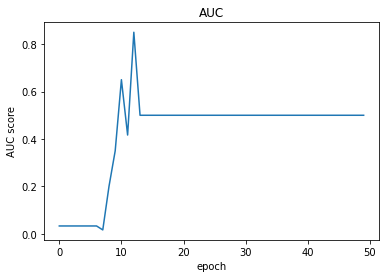

In [58]:


plt.plot(fttotauc[:50])
plt.title("AUC")
plt.ylabel("AUC score")
plt.xlabel("epoch")


